# Combining Raw Data
Chapter 4 of the book: "Build Your Own AI Investor"

In [6]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [7]:
from platform import python_version
print(python_version())

3.9.17


In [8]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [12]:
#def getXDataMerged(myLocalPath='C:/Users/damon/Stock_Data/SimFin2023/'):
def getXDataMerged(myLocalPath='C:/Users/damon/OneDrive/BYO_Investing_AI/2024/Stock_Data/SimFin2024/'):
    '''
    For combining fundamentals financial data from SimFin,
    or SimFin+ (https://simfin.com/) without API.
    Download Income Statement, Balance Sheet and Cash Flow files,
    Place in a directory and give the directory path to the function.
    Assumes standard filenames from SimFin.
    Returns a DataFrame of the combined result. 
    Prints file infos.
    '''
    incomeStatementData = pd.read_csv(myLocalPath+'us-income-annual-full-asreported.csv', 
                delimiter=';')
    balanceSheetData = pd.read_csv(myLocalPath+'us-balance-annual-full-asreported.csv',
                delimiter=';')
    CashflowData = pd.read_csv(myLocalPath+'us-cashflow-annual-full-asreported.csv',
                delimiter=';')
    
    print('Income Statement CSV data is(rows, columns): ',
          incomeStatementData.shape)
    print('Balance Sheet CSV data is: ',
          balanceSheetData.shape)
    print('Cash Flow CSV data is: ' ,
          CashflowData.shape)
    

    # Merge the data together
    result = pd.merge(incomeStatementData, balanceSheetData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    result = pd.merge(result, CashflowData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    # dates in correct format
    result["Report Date"] = pd.to_datetime(result["Report Date"]) 
    result["Publish Date"] = pd.to_datetime(result["Publish Date"])
    
    print('Merged X data matrix shape is: ', result.shape)
    
    return result

In [20]:
def getYRawData(my_local_path='C:/Users/damon/OneDrive/BYO_Investing_AI/2024/Stock_Data/SimFin2024/'):
    '''
    Read stock price data from SimFin or SimFin+ (https://simfin.com/),
    without API.
    Place in a directory and give the directory path to the function.
    Assumes standard filenames from SimFin.
    Returns a DataFrame.
    Prints file info.
    '''
    dailySharePrices=pd.read_csv(my_local_path+
                                 'us-shareprices-daily.csv',
                                 delimiter=';')
    
    dailySharePrices["Date"]=pd.to_datetime(dailySharePrices["Date"])
    print('Stock Price data matrix is: ',dailySharePrices.shape)
    return dailySharePrices

In [21]:
def getYPriceDataNearDate(ticker, date, modifier, dailySharePrices):
    '''
    Return just the y price and volume.
    Take the first day price/volume of the list of days,
    that fall in the window of accepted days.
    'modifier' just modifies the date to look between.
    Returns a list.
    '''
    windowDays=5
    rows = dailySharePrices[
        (dailySharePrices["Date"].between(pd.to_datetime(date)
                                          + pd.Timedelta(days=modifier),
                                          pd.to_datetime(date)
                                          + pd.Timedelta(days=windowDays
                                                         +modifier)
                                         )
        ) & (dailySharePrices["Ticker"]==ticker)]
    
    if rows.empty:
        return [ticker, np.nan,\
                np.datetime64('NaT'),\
                np.nan]
    else:
        return [ticker, rows.iloc[0]["Open"],\
                rows.iloc[0]["Date"],\
                rows.iloc[0]["Volume"]*rows.iloc[0]["Open"]]

In [22]:
d=getYRawData()

Stock Price data matrix is:  (17999010, 11)


In [8]:
getYPriceDataNearDate('AAPL', '2012-05-12', 0, d)

['AAPL', 20.09, Timestamp('2012-05-14 00:00:00'), 7084271467.7699995]

In [9]:
getYPriceDataNearDate('AAPL', '2023-02-06', 30, d)

['AAPL', 152.81, Timestamp('2023-03-08 00:00:00'), 7213364112.71]

In [10]:
def getYPricesReportDateAndTargetDate(x, d, modifier=365):
    '''
    Takes in all fundamental data X, all stock prices over time y,
    and modifier (days), and returns the stock price info for the
    data report date, as well as the stock price one year from that date
    (if modifier is left as modifier=365)
    '''
    # Preallocation list of list of 2 
    # [(price at date) (price at date + modifier)]
    y = [[None]*8 for i in range(len(x))] 
    
    whichDateCol='Publish Date'# or 'Report Date', 
    # is the performance date from->to. Want this to be publish date.
    
    # Because of time lag between report date
    # (which can't be actioned on) and publish date
    # (data we can trade with)
    
    # In the end decided this instead of iterating through index.
    # Iterate through a range rather than index, as X might not have
    # monotonic increasing index 1, 2, 3, etc.
    i=0
    for index in range(len(x)):
        y[i]=(getYPriceDataNearDate(x['Ticker'].iloc[index], 
                                    x[whichDateCol].iloc[index],0,d)
              +getYPriceDataNearDate(x['Ticker'].iloc[index], 
                                     x[whichDateCol].iloc[index], 
                                     modifier, d))
        i=i+1
        
    return y

In [11]:
'''def getYPricesReportDateAndTargetDate(x, d, modifier=365):
    '''
    #Takes in all fundamental data X, all stock prices over time y,
    #and modifier (days), and returns the stock price info for the
    #data report date, as well as the stock price one year from that date
    #(if modifier is left as modifier=365)
    '''
    # Preallocation list of list of 2 
    # [(price at date) (price at date + modifier)]
    y = [[None]*8 for i in range(len(x))] 
    
    whichDateCol='Publish Date'# or 'Report Date', 
    # is the performance date from->to. Want this to be publish date.
    
    # Because of time lag between report date
    # (which can't be actioned on) and publish date
    # (data we can trade with)

    for i in x.index:
        y[i]=(getYPriceDataNearDate(x['Ticker'].loc[i], 
                                    x[whichDateCol].loc[i],0,d)
              +getYPriceDataNearDate(x['Ticker'].loc[i], 
                                     x[whichDateCol].loc[i], 
                                     modifier, d))
        
    return y'''

IndentationError: unexpected indent (3690593226.py, line 7)

In [13]:
X = getXDataMerged()
X.to_csv("Annual_Stock_Price_Fundamentals.csv")

Income Statement CSV data is(rows, columns):  (53643, 68)
Balance Sheet CSV data is:  (53643, 95)
Cash Flow CSV data is:  (53643, 62)
Merged X data matrix shape is:  (40824, 213)


In [19]:
for key in X.keys():
    print(key)

Ticker
SimFinId
Currency
Fiscal Year
Fiscal Period_x
Report Date
Publish Date
Restated Date_x
Shares (Basic)_x
Shares (Diluted)_x
Revenue
Sales & Services Revenue
Financing Revenue
Other Revenue
Cost of Revenue
Cost of Goods & Services
Cost of Financing Revenue
Cost of Other Revenue
Gross Profit
Other Operating Income
Operating Expenses
Selling, General & Administrative
Selling & Marketing
General & Administrative
Research & Development
Depreciation & Amortization_x
Provision for Doubtful Accounts
Other Operating Expenses
Operating Income (Loss)
Non-Operating Income (Loss)
Interest Expense, Net
Interest Expense
Interest Income
Other Investment Income (Loss)
Foreign Exchange Gain (Loss)
Income (Loss) from Affiliates
Other Non-Operating Income (Loss)
Pretax Income (Loss), Adj.
Abnormal Gains (Losses)
Acquired In-Process R&D
Merger & Acquisition Expense
Abnormal Derivatives
Disposal of Assets
Early Extinguishment of Debt
Asset Write-Down
Impairment of Goodwill & Intangibles
Sale of Busine

In [43]:
d = getYRawData()
d[d['Ticker']=='GOOG']

Stock Price data matrix is:  (17796403, 11)


,Ticker,SimFinId,Date,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding
6920241,GOOG,18,2014-03-27,28.40,28.40,27.65,27.92,27.92,262000,NaN,6.721017e+09
6920242,GOOG,18,2014-03-28,28.06,28.32,27.93,28.00,28.00,822000,NaN,6.721017e+09
6920243,GOOG,18,2014-03-31,28.34,28.35,27.85,27.85,27.85,216000,NaN,1.348924e+10
6920244,GOOG,18,2014-04-01,27.94,28.42,27.94,28.36,28.36,158000,NaN,1.348924e+10
6920245,GOOG,18,2014-04-02,28.26,30.24,28.11,28.35,28.35,2934000,NaN,1.348924e+10
...,...,...,...,...,...,...,...,...,...,...,...
6922738,GOOG,18,2024-02-28,139.10,139.28,136.64,137.43,137.43,30424964,NaN,1.258100e+10
6922739,GOOG,18,2024-02-29,138.35,139.95,137.57,139.78,139.78,35406722,NaN,1.258100e+10
6922740,GOOG,18,2024-03-01,139.61,140.00,137.97,138.08,138.08,28460551,NaN,1.258100e+10
6922741,GOOG,18,2024-03-04,136.54,136.63,132.86,134.20,134.20,43208390,NaN,1.258100e+10


### \**Warning** takes a long time

In [44]:
# We want to know the performance for each stock, each year, between 10-K report dates.
# takes VERY long time, several hours,
y = getYPricesReportDateAndTargetDate(X, d, 365) # because of lookups in this function.

In [45]:
y = pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume',\
                             'Ticker2', 'Open Price2', 'Date2', 'Volume2'
                            ])
y.to_csv("Annual_Stock_Price_Performance.csv")

In [46]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,28.40,2002-01-22,44130760.00,A,17.55,2003-01-22,3.857666e+07
1,A,16.80,2002-12-20,61365360.00,A,28.00,2003-12-22,5.727120e+07
2,A,28.00,2003-12-22,57271200.00,A,23.52,2004-12-21,4.270526e+07
3,A,23.52,2004-12-21,42705264.00,A,34.99,2005-12-21,1.473569e+08
4,A,33.67,2006-01-17,84215404.00,A,33.43,2007-01-17,8.902743e+07
...,...,...,...,...,...,...,...,...
40786,ZYXI,0.31,2017-04-18,3528.73,ZYXI,3.15,2018-04-18,1.889842e+05
40787,ZYXI,11.25,2020-02-27,4283403.75,ZYXI,14.55,2021-02-26,3.741924e+07
40788,ZYXI,16.78,2021-02-25,7177796.02,ZYXI,6.37,2022-02-25,3.262262e+06
40789,ZYXI,5.83,2022-03-22,2018882.36,ZYXI,11.12,2023-03-22,1.456520e+06


# Long part done, now remove rows with issues

In [7]:
X=pd.read_csv("Annual_Stock_Price_Fundamentals.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance.csv", index_col=0)

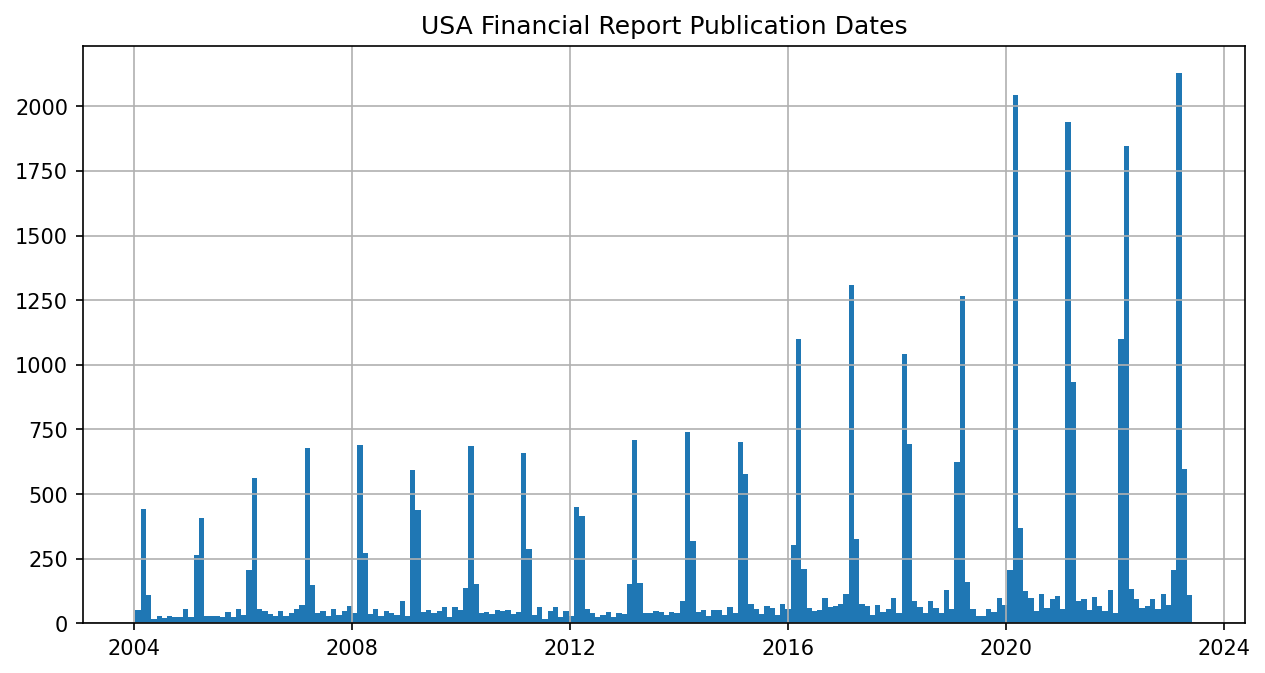

In [8]:
X['Publish Date'] = pd.to_datetime(X['Publish Date'])
X[(X['Publish Date'] > '2004-01-01') & 
  (X['Publish Date'] < '2023-06-01')]['Publish Date'].hist(bins=200, 
                                                          figsize=(10,5))
plt.title('USA Financial Report Publication Dates');

In [53]:
# Find out things about data visually.
#X[X["Ticker"]=="GOOG"]['Income (Loss) from Continuing Operations'].hist()#bins=50, figsize=(20,15))
#X.keys()

#X.describe()
#X.hist(bins=50, figsize=(20,15))

In [54]:
for i in X.columns:
    print(i)

Ticker
SimFinId
Currency
Fiscal Year
Fiscal Period_x
Report Date
Publish Date
Restated Date_x
Shares (Basic)_x
Shares (Diluted)_x
Revenue
Sales & Services Revenue
Financing Revenue
Other Revenue
Cost of Revenue
Cost of Goods & Services
Cost of Financing Revenue
Cost of Other Revenue
Gross Profit
Other Operating Income
Operating Expenses
Selling, General & Administrative
Selling & Marketing
General & Administrative
Research & Development
Depreciation & Amortization_x
Provision for Doubtful Accounts
Other Operating Expenses
Operating Income (Loss)
Non-Operating Income (Loss)
Interest Expense, Net
Interest Expense
Interest Income
Other Investment Income (Loss)
Foreign Exchange Gain (Loss)
Income (Loss) from Affiliates
Other Non-Operating Income (Loss)
Pretax Income (Loss), Adj.
Abnormal Gains (Losses)
Acquired In-Process R&D
Merger & Acquisition Expense
Abnormal Derivatives
Disposal of Assets
Early Extinguishment of Debt
Asset Write-Down
Impairment of Goodwill & Intangibles
Sale of Busine

C:\Users\damon\.conda\envs\AIInvestor\lib\site-packages\pandas\plotting\_matplotlib\misc.py:122: RuntimeWarning: invalid value encountered in cast
  if np.all(locs == locs.astype(int)):


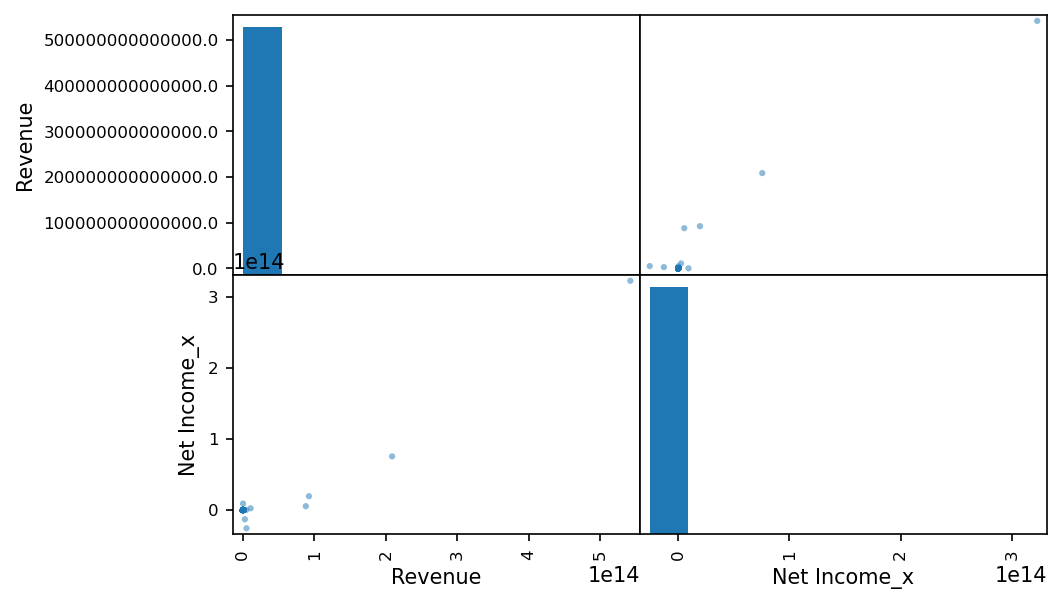

In [55]:
from pandas.plotting import scatter_matrix
attributes=["Revenue","Net Income_x"]
scatter_matrix(X[attributes]);

In [56]:
# Find out things about Y data
print("y Shape:", y.shape)
print("X Shape:", X.shape)

y Shape: (40791, 8)
X Shape: (40791, 213)


In [57]:
y[(y['Volume']<1e4) | (y['Volume2']<1e4)]# rows with volume issues

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
38,AACI,9.80,2021-12-29,88415.60,AACI,10.10,2022-12-29,101.00
39,AACI,10.06,2022-12-22,30.18,AACI,10.72,2023-12-22,117.92
46,AAGH,0.02,2018-12-03,20.00,AAGH,0.01,2019-12-05,1976.08
47,AAGH,0.14,2021-03-23,7219.10,AAGH,0.06,2022-03-23,1411.50
48,AAGH,0.00,2022-01-21,0.00,AAGH,0.01,2023-01-23,0.00
...,...,...,...,...,...,...,...,...
40782,ZYXI,0.39,2014-03-28,56.16,ZYXI,0.12,2015-03-30,484.32
40783,ZYXI,0.12,2015-03-31,165.00,ZYXI,0.31,2016-03-30,0.00
40784,ZYXI,0.31,2016-03-31,34.41,ZYXI,0.28,2017-03-31,215.60
40785,ZYXI,0.29,2017-04-17,5670.95,ZYXI,2.95,2018-04-17,78779.75


In [58]:
# Now need to filter out rows because not all of the rows have stock performance.

In [59]:
## PROBLEMS
# no accounting for mergers or bankrupcies (use adjusted share closing price)

In [60]:
y.shape

(40791, 8)

In [61]:
# Issue where no share price
bool_list1 = ~y["Open Price"].isnull()
# Issue where there is low/no volume
bool_list2 = ~((y['Volume']<1e4) | (y['Volume2']<1e4))
# Issue where dates missing (Removes latest data too, which we can't use)
bool_list3 = ~y["Date2"].isnull()

y=y[bool_list1 & bool_list2 & bool_list3]
X=X[bool_list1 & bool_list2 & bool_list3]


# Issues where no listed number of shares
bool_list4 = ~X["Shares (Diluted)_x"].isnull()
y=y[bool_list4]
X=X[bool_list4]
               
y=y.reset_index(drop=True)
X=X.reset_index(drop=True)

In [62]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,28.40,2002-01-22,44130760.00,A,17.55,2003-01-22,3.857666e+07
1,A,16.80,2002-12-20,61365360.00,A,28.00,2003-12-22,5.727120e+07
2,A,28.00,2003-12-22,57271200.00,A,23.52,2004-12-21,4.270526e+07
3,A,23.52,2004-12-21,42705264.00,A,34.99,2005-12-21,1.473569e+08
4,A,33.67,2006-01-17,84215404.00,A,33.43,2007-01-17,8.902743e+07
...,...,...,...,...,...,...,...,...
31048,ZYNE,4.58,2021-03-10,7940089.52,ZYNE,1.95,2022-03-10,6.412887e+05
31049,ZYNE,2.22,2022-03-01,920163.36,ZYNE,0.50,2023-03-01,1.532925e+05
31050,ZYXI,11.25,2020-02-27,4283403.75,ZYXI,14.55,2021-02-26,3.741924e+07
31051,ZYXI,16.78,2021-02-25,7177796.02,ZYXI,6.37,2022-02-25,3.262262e+06


In [63]:
X["Market Cap"] = y["Open Price"]*X["Shares (Diluted)_x"]

In [64]:
X.shape

(31053, 214)

In [65]:
y.shape

(31053, 8)

In [66]:
X.to_csv("Annual_Stock_Price_Fundamentals_Filtered.csv")
y.to_csv("Annual_Stock_Price_Performance_Filtered.csv")

In [67]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,28.40,2002-01-22,44130760.00,A,17.55,2003-01-22,3.857666e+07
1,A,16.80,2002-12-20,61365360.00,A,28.00,2003-12-22,5.727120e+07
2,A,28.00,2003-12-22,57271200.00,A,23.52,2004-12-21,4.270526e+07
3,A,23.52,2004-12-21,42705264.00,A,34.99,2005-12-21,1.473569e+08
4,A,33.67,2006-01-17,84215404.00,A,33.43,2007-01-17,8.902743e+07
...,...,...,...,...,...,...,...,...
31048,ZYNE,4.58,2021-03-10,7940089.52,ZYNE,1.95,2022-03-10,6.412887e+05
31049,ZYNE,2.22,2022-03-01,920163.36,ZYNE,0.50,2023-03-01,1.532925e+05
31050,ZYXI,11.25,2020-02-27,4283403.75,ZYXI,14.55,2021-02-26,3.741924e+07
31051,ZYXI,16.78,2021-02-25,7177796.02,ZYXI,6.37,2022-02-25,3.262262e+06


In [68]:
X[80:90]

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Decrease in Capital Stock,Other Financing Activities,Net Cash from Discontinued Operations (Financing),Net Cash from Financing Activities,Net Cash Before Disc. Operations and FX,Change in Cash from Disc. Operations and Other,Net Cash Before FX,Effect of Foreign Exchange Rates,Net Change in Cash,Market Cap
80,AAPL,111052,USD,2008,FY,2008-09-30,2008-11-05,2008-11-05,2.468458e+10,2.525989e+10,...,NaN,6.330000e+08,NaN,1.116000e+09,2523000000,NaN,2523000000,NaN,2523000000,9.826098e+10
81,AAPL,111052,USD,2009,FY,2009-09-30,2009-10-27,2009-10-27,2.500445e+10,2.539614e+10,...,NaN,1.880000e+08,NaN,6.630000e+08,-6612000000,NaN,-6612000000,NaN,-6612000000,1.828522e+11
82,AAPL,111052,USD,2010,FY,2010-09-30,2010-10-27,2010-10-27,2.546491e+10,2.589194e+10,...,NaN,3.450000e+08,NaN,1.257000e+09,5998000000,NaN,5998000000,NaN,5998000000,2.845524e+11
83,AAPL,111052,USD,2011,FY,2011-09-30,2011-10-26,2011-10-26,2.587922e+10,2.622606e+10,...,NaN,6.130000e+08,NaN,1.444000e+09,-1446000000,NaN,-1446000000,NaN,-1446000000,3.763440e+11
84,AAPL,111052,USD,2012,FY,2012-09-30,2012-10-31,2012-10-31,2.617490e+10,2.646993e+10,...,NaN,1.250000e+08,NaN,-1.698000e+09,931000000,NaN,931000000,NaN,931000000,5.624861e+11
85,AAPL,111052,USD,2013,FY,2013-09-30,2013-10-30,2013-10-30,2.590928e+10,2.608654e+10,...,-2.286000e+10,-3.810000e+08,NaN,-1.637900e+10,3513000000,NaN,3513000000,NaN,3513000000,4.841661e+11
86,AAPL,111052,USD,2014,FY,2014-09-30,2014-10-27,2014-10-27,2.434229e+10,2.449065e+10,...,-4.500000e+10,-4.190000e+08,NaN,-3.754900e+10,-415000000,NaN,-415000000,NaN,-415000000,6.419000e+11
87,AAPL,111052,USD,2015,FY,2015-09-30,2015-10-28,2015-10-28,2.301368e+10,2.317228e+10,...,-3.525300e+10,-7.500000e+08,NaN,-1.771600e+10,7276000000,NaN,7276000000,NaN,7276000000,6.773256e+11
88,AAPL,111052,USD,2016,FY,2016-09-30,2016-10-26,2016-10-26,2.188328e+10,2.200112e+10,...,-2.972200e+10,-1.163000e+09,NaN,-2.048300e+10,-636000000,NaN,-636000000,NaN,-636000000,6.287921e+11
89,AAPL,111052,USD,2017,FY,2017-09-30,2017-11-03,2017-11-03,2.086897e+10,2.100677e+10,...,-3.290000e+10,-1.247000e+09,NaN,-1.734700e+10,-195000000,NaN,-195000000,NaN,-195000000,9.137944e+11


# X Data for Final Stock Selection 2024
Requires SimFin+ Bulk Download

## Get the Latest Share Prices (To make Market Cap. Column Soon)

In [13]:
def getYRawData2024(my_path = 'C:/Users/damon/OneDrive/BYO_Investing_AI/2024/Stock_Data/SimFin2024/'):
    d=pd.read_csv(my_path + 'us-shareprices-daily.csv', delimiter=';')
    d["Date"]=pd.to_datetime(d["Date"])
    print('Stock Price data matrix is: ',d.shape)
    return d

In [14]:
d=getYRawData2024()

Stock Price data matrix is:  (17999010, 11)


In [15]:
getYPriceDataNearDate('AAPL', '2024-03-05', 0, d)

['AAPL', 170.76, Timestamp('2024-03-05 00:00:00'), 16244800939.8]

## Functions to Extract Price at Time We Need and Combine X Data

In [16]:
def getYPricesReportDate(X, d, modifier=365):
    '''
    Get the stock prices for our X matrix to create Market Cap. column later.
    '''
    i=0
    y = [[None]*8 for i in range(len(X))] # Preallocation list of list of 2 [(price at date) (price at date + modifier)]
    whichDateCol='Publish Date'# or 'Report Date', is the performance date from->to. Want this to be publish date.
    # Because of time lag between report date (which can't be actioned on) and publish date (data we can trade with)
    for index in range(len(X)):
        y[i]=getYPriceDataNearDate(X['Ticker'].iloc[index], X[whichDateCol].iloc[index], 0, d)
        i=i+1
    return y

In [17]:
def getXFullDataMerged(myLocalPath='C:/Users/damon/OneDrive/BYO_Investing_AI/2024/Stock_Data/SimFin2024/'):
    '''
    For combining fundamentals financial data from SimFin+ only,
    without API. 
    Download Income Statement, Balance Sheet and Cash Flow files,
    the -full versions, e.g. us-balance-annual-full.csv.
    Place in a directory and give the directory path to the function.
    Assumes standard filenames from SimFin.
    Returns a DataFrame of the combined result. 
    Prints file infos.
    '''
    incomeStatementData=pd.read_csv(myLocalPath+'us-income-annual-full-asreported.csv',
                                    delimiter=';')
    balanceSheetData=pd.read_csv(myLocalPath+'us-balance-annual-full-asreported.csv',
                                 delimiter=';')
    CashflowData=pd.read_csv(myLocalPath+'us-cashflow-annual-full-asreported.csv',
                             delimiter=';')
    
    print('Income Statement CSV data is(rows, columns): ',
          incomeStatementData.shape)
    print('Balance Sheet CSV data is: ',
          balanceSheetData.shape)
    print('Cash Flow CSV data is: ' ,
          CashflowData.shape)
    

    # Merge the data together
    result = pd.merge(incomeStatementData, balanceSheetData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    result = pd.merge(result, CashflowData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    # dates in correct format
    result["Report Date"] = pd.to_datetime(result["Report Date"]) 
    result["Publish Date"] = pd.to_datetime(result["Publish Date"])
    
    print('Merged X data matrix shape is: ', result.shape)
    
    return result

In [18]:
#OLD
'''#https://simfin.com/
def getXDataMerged():
    a=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/2020/us-income-annual-full.csv', delimiter=';')
    b=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/2020/us-balance-annual-full.csv', delimiter=';')
    c=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/2020/us-cashflow-annual-full.csv', delimiter=';')
    print('Income Statement CSV is: ', a.shape)
    print('Balance Sheet CSV is: ', b.shape)
    print('Cash Flow CSV is: ' ,c.shape)
    result = pd.merge(a, b, on=['Ticker','SimFinId','Currency','Fiscal Year','Report Date','Publish Date'])
    result = pd.merge(result, c, on=['Ticker','SimFinId','Currency','Fiscal Year','Report Date','Publish Date'])
    result["Report Date"] = pd.to_datetime(result["Report Date"])
    result["Publish Date"] = pd.to_datetime(result["Publish Date"])
    print('merged X data matrix shape is:', result.shape)
    return result'''

'#https://simfin.com/\ndef getXDataMerged():\n    a=pd.read_csv(\'C:/Users/G50/Stock_Data/SimFin/2020/us-income-annual-full.csv\', delimiter=\';\')\n    b=pd.read_csv(\'C:/Users/G50/Stock_Data/SimFin/2020/us-balance-annual-full.csv\', delimiter=\';\')\n    c=pd.read_csv(\'C:/Users/G50/Stock_Data/SimFin/2020/us-cashflow-annual-full.csv\', delimiter=\';\')\n    print(\'Income Statement CSV is: \', a.shape)\n    print(\'Balance Sheet CSV is: \', b.shape)\n    print(\'Cash Flow CSV is: \' ,c.shape)\n    result = pd.merge(a, b, on=[\'Ticker\',\'SimFinId\',\'Currency\',\'Fiscal Year\',\'Report Date\',\'Publish Date\'])\n    result = pd.merge(result, c, on=[\'Ticker\',\'SimFinId\',\'Currency\',\'Fiscal Year\',\'Report Date\',\'Publish Date\'])\n    result["Report Date"] = pd.to_datetime(result["Report Date"])\n    result["Publish Date"] = pd.to_datetime(result["Publish Date"])\n    print(\'merged X data matrix shape is:\', result.shape)\n    return result'

## Get X Data (2023/24)

In [19]:
X = getXFullDataMerged()

Income Statement CSV data is(rows, columns):  (53643, 68)
Balance Sheet CSV data is:  (53643, 95)
Cash Flow CSV data is:  (53643, 62)
Merged X data matrix shape is:  (40824, 213)


In [20]:
X['Publish Date'].sort_values()

30840   1992-01-01
10612   1992-10-01
30841   1993-01-01
10613   1993-10-01
30842   1994-01-01
           ...    
38136   2024-03-15
28233   2024-03-15
10934   2024-03-15
17499   2024-03-15
5895    2024-03-15
Name: Publish Date, Length: 40824, dtype: datetime64[ns]

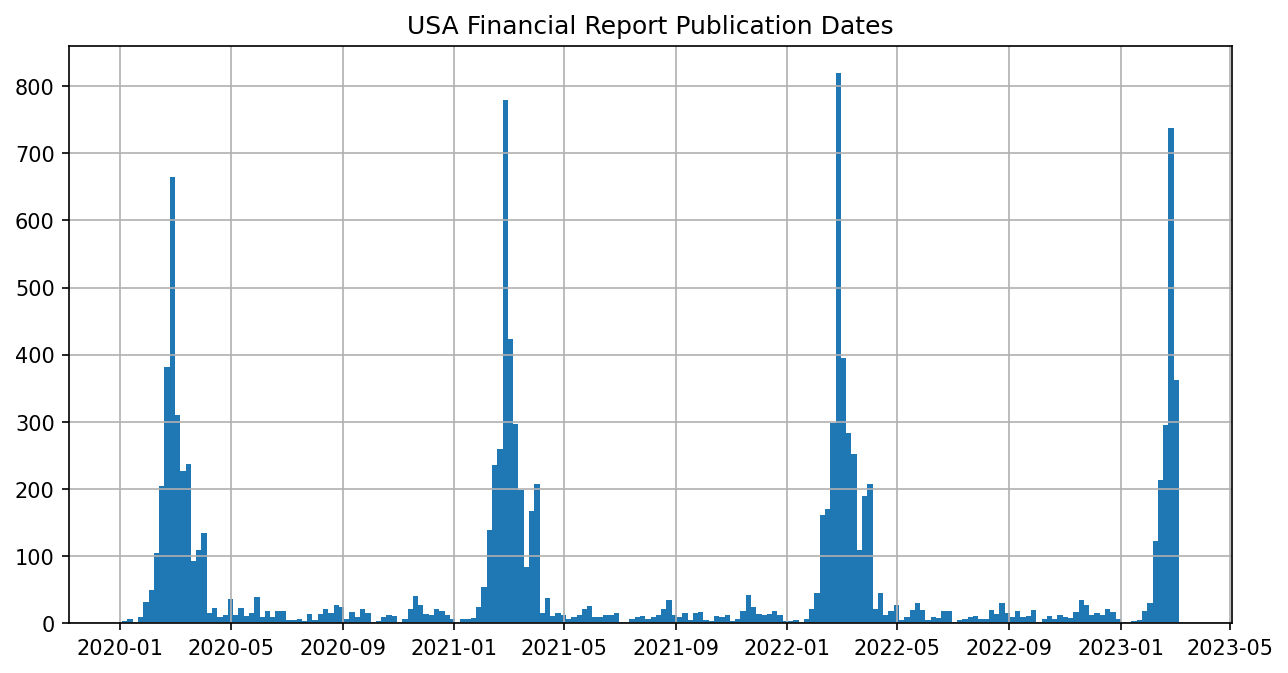

In [45]:
X['Publish Date'] = pd.to_datetime(X['Publish Date'])
X[(X['Publish Date'] > '2020-01-01') & 
  (X['Publish Date'] < '2023-03-07')]['Publish Date'].hist(bins=200, 
                                                          figsize=(10,5))
plt.title('USA Financial Report Publication Dates');

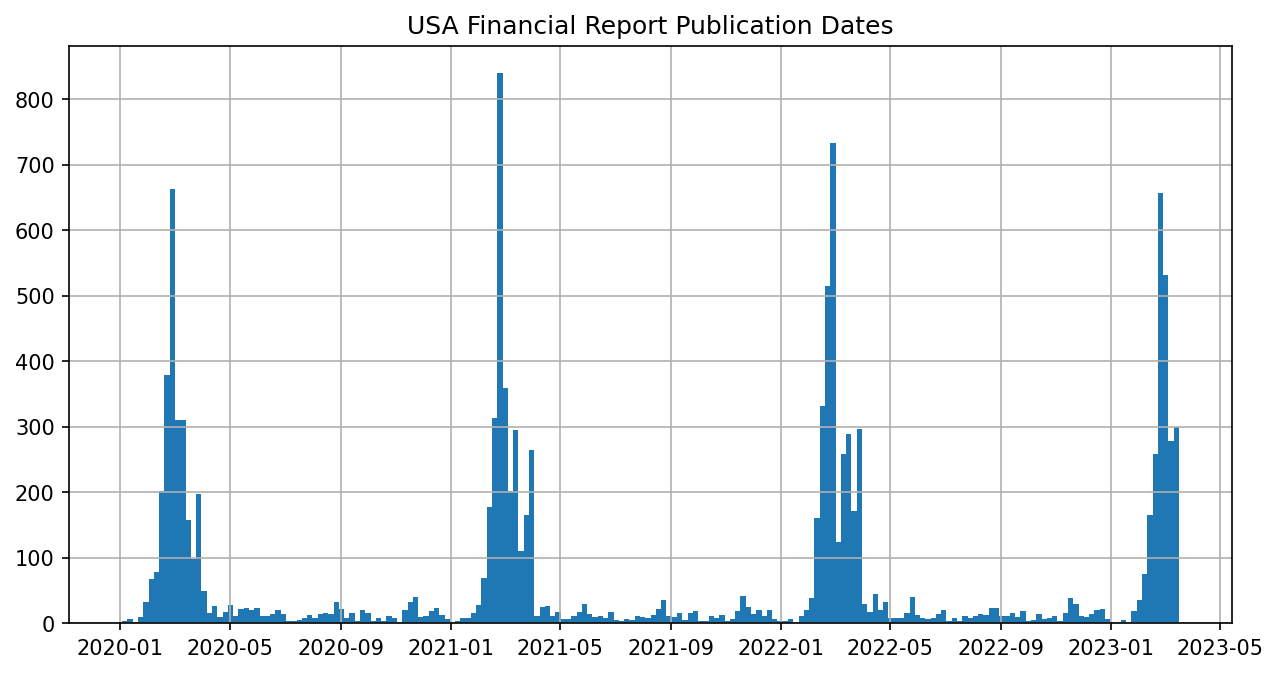

In [22]:
X['Publish Date'] = pd.to_datetime(X['Publish Date'])
X[(X['Publish Date'] > '2020-01-01') & 
  (X['Publish Date'] < '2023-03-18')]['Publish Date'].hist(bins=200, 
                                                          figsize=(10,5))
plt.title('USA Financial Report Publication Dates');

In [23]:
# Get data only for 2024
PublishDateStart = "2024-01-01"
PublishDateEnd = "2024-04-01"
bool_list = X['Publish Date'].between(\
              pd.to_datetime(PublishDateStart),\
              pd.to_datetime(PublishDateEnd) )
X=X[bool_list]

In [24]:
X

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Increase in Capital Stock,Decrease in Capital Stock,Other Financing Activities,Net Cash from Discontinued Operations (Financing),Net Cash from Financing Activities,Net Cash Before Disc. Operations and FX,Change in Cash from Disc. Operations and Other,Net Cash Before FX,Effect of Foreign Exchange Rates,Net Change in Cash
35,AA,367153,USD,2023,FY,2023-12-31,2024-02-21,2024-02-21,178000000.0,178000000.0,...,1000000.0,NaN,84000000.0,NaN,6.800000e+07,-437000000,NaN,-437000000,10000000.0,-427000000
73,AAL,68568,USD,2023,FY,2023-12-31,2024-02-21,2024-02-21,653612000.0,719669000.0,...,NaN,NaN,-310000000.0,NaN,-3.206000e+09,95000000,NaN,95000000,NaN,95000000
95,AAOI,671827,USD,2023,FY,2023-12-31,2024-02-23,2024-02-23,31944259.0,31944259.0,...,69006000.0,NaN,-956000.0,NaN,4.057800e+07,17888000,NaN,17888000,1622000.0,19510000
146,AAT,919944,USD,2023,FY,2023-12-31,2024-02-14,2024-02-14,60158976.0,76340513.0,...,NaN,NaN,-2976000.0,NaN,-6.554700e+07,33317000,NaN,33317000,NaN,33317000
149,AAWH,2265764,USD,2023,FY,2023-12-31,2024-03-13,2024-03-13,199154000.0,199154000.0,...,7186000.0,NaN,-711000.0,NaN,-1.708200e+07,-1638000,NaN,-1638000,NaN,-1638000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40729,ZNTE,1816642,USD,2023,FY,2023-12-31,2024-03-08,2024-03-08,275763000.0,275763000.0,...,NaN,NaN,-530000.0,NaN,2.492600e+07,-2750000,NaN,-2750000,487000.0,-2263000
40733,ZNTL,11795126,USD,2023,FY,2023-12-31,2024-02-27,2024-02-27,65409000.0,65409000.0,...,237303000.0,NaN,NaN,NaN,2.373030e+08,-14977000,NaN,-14977000,NaN,-14977000
40759,ZTS,378251,USD,2023,FY,2023-12-31,2024-02-13,2024-02-13,461172000.0,462269000.0,...,NaN,-1.092000e+09,24000000.0,NaN,-3.109000e+09,-1533000000,NaN,-1533000000,-7000000.0,-1540000000
40771,ZUMZ,45730,USD,2023,FY,2024-01-31,2024-03-14,2024-03-14,19290000.0,19290000.0,...,704000.0,NaN,NaN,NaN,7.040000e+05,6911000,NaN,6911000,-1080000.0,5831000


## Get Y Data

In [26]:
y = getYPricesReportDate(X, d) # Takes a min due to price lookups.
y = pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume'])

In [27]:
y

,Ticker,Open Price,Date,Volume
0,AA,27.12,2024-02-21,1.530134e+08
1,AAL,14.59,2024-02-21,3.339297e+08
2,AAOI,13.74,2024-02-23,2.668717e+08
3,AAT,21.78,2024-02-14,6.233850e+06
4,AAWH,1.15,2024-03-13,7.758647e+05
...,...,...,...,...
1644,ZNTE,5.27,2024-03-08,2.021150e+05
1645,ZNTL,14.42,2024-02-27,1.746478e+07
1646,ZTS,186.60,2024-02-13,7.577229e+08
1647,ZUMZ,15.44,2024-03-14,8.119881e+06


In [28]:
y['Ticker']

0         AA
1        AAL
2       AAOI
3        AAT
4       AAWH
        ... 
1644    ZNTE
1645    ZNTL
1646     ZTS
1647    ZUMZ
1648    ZUUS
Name: Ticker, Length: 1649, dtype: object

In [29]:
import yfinance as yf

# Replace 'AAPL' with the ticker symbol of the stock you want to fetch data for
ticker_symbol = 'WMT'

# Create a yfinance object for the specified stock
stock = yf.Ticker(ticker_symbol)

# Get historical data for the stock with the 'history' method
# By default, it will return data for the last available trading day
historical_data = stock.history(period="1d")

# Extract the open price from the historical data
open_price = historical_data['Open'].iloc[0]

print(f"Open price for {ticker_symbol}: {open_price}")


Open price for WMT: 60.68000030517578


In [30]:
import yfinance as yf
openPrices = {}
for sym in y['Ticker']:
    # Replace 'AAPL' with the ticker symbol of the stock you want to fetch data for
    ticker_symbol = sym

    # Create a yfinance object for the specified stock
    stock = yf.Ticker(ticker_symbol)
    # Get historical data for the stock with the 'history' method
    # By default, it will return data for the last available trading day
    historical_data = stock.history(period="1d")
    if not historical_data.empty:
        # Extract the open price from the historical data
        open_price = historical_data['Open'].iloc[0]

        print(f"Open price for {ticker_symbol}: {open_price}")
        openPrices[ticker_symbol] = open_price

Open price for AA: 29.899999618530273
Open price for AAL: 13.960000038146973
Open price for AAOI: 12.880000114440918
Open price for AAT: 20.829999923706055
Open price for AAWH: 1.0700000524520874
Open price for ABBV: 179.83999633789062
Open price for ABG: 204.02999877929688
Open price for ABIO: 1.7300000190734863
Open price for ABNB: 166.38999938964844
Open price for ABT: 113.0199966430664
Open price for ABUS: 2.5899999141693115
Open price for ABVC: 1.2100000381469727
Open price for ACA: 80.37000274658203
Open price for ACAD: 18.6200008392334
Open price for ACCO: 5.239999771118164
Open price for ACEL: 11.210000038146973
Open price for ACHC: 78.31999969482422
Open price for ACHR: 4.889999866485596
Open price for ACIW: 31.200000762939453
Open price for ACLS: 106.55999755859375
Open price for ACLX: 68.77999877929688
Open price for ACMR: 27.100000381469727
Open price for ACRE: 7.5
Open price for ACRS: 1.1399999856948853
Open price for ACTG: 4.300000190734863
Open price for ACU: 39.70999908

AMHCU: No data found, symbol may be delisted


Open price for AMK: 35.75
Open price for AMKR: 31.110000610351562
Open price for AMLX: 3.119999885559082
Open price for AMN: 57.130001068115234


AMOT: No data found, symbol may be delisted


Open price for AMPH: 43.15999984741211
Open price for AMPL: 10.930000305175781
Open price for AMPY: 6.03000020980835
Open price for AMRX: 5.360000133514404
Open price for AMWL: 0.8840000033378601
Open price for AN: 154.89999389648438
Open price for ANAB: 23.600000381469727
Open price for ANDE: 52.9900016784668
Open price for ANET: 279.17999267578125
Open price for ANGI: 2.619999885559082
Open price for ANIK: 24.40999984741211
Open price for ANIP: 65.88999938964844
Open price for ANIX: 3.1500000953674316
Open price for ANSS: 328.8500061035156
Open price for ANY: 1.309999942779541
Open price for AOMR: 10.170000076293945
Open price for AON: 317.9800109863281
Open price for AOS: 86.04000091552734
Open price for APAM: 42.45000076293945
Open price for APEI: 12.4399995803833
Open price for APG: 37.880001068115234
Open price for APGE: 65.3499984741211
Open price for APH: 108.56999969482422
Open price for APLE: 16.15999984741211
Open price for APLS: 55.9900016784668
Open price for APPF: 221.339

APY: No data found, symbol may be delisted


Open price for AQST: 5.409999847412109
Open price for AR: 25.90999984741211
Open price for ARCB: 128.67999267578125
Open price for ARCH: 161.9199981689453
Open price for ARCT: 36.040000915527344
Open price for ARDX: 8.020000457763672
Open price for ARHS: 15.4399995803833
Open price for ARIS: 13.0
Open price for ARKO: 5.550000190734863
Open price for ARLO: 12.029999732971191
Open price for ARLP: 19.790000915527344
Open price for AROC: 18.610000610351562


ARPO: No data found, symbol may be delisted


Open price for ARQT: 10.869999885559082
Open price for ARVN: 44.470001220703125
Open price for ASAN: 15.920000076293945
Open price for ASC: 16.709999084472656
Open price for ASGN: 100.51000213623047
Open price for ASIX: 25.889999389648438
Open price for ASLE: 7.230000019073486
Open price for ASPN: 15.239999771118164
Open price for ASRT: 1.0800000429153442
Open price for ASTE: 39.939998626708984
Open price for ATEC: 13.239999771118164
Open price for ATEN: 14.170000076293945
Open price for ATHA: 2.549999952316284
Open price for ATI: 47.93000030517578
Open price for ATLC: 30.0
Open price for ATMU: 26.200000762939453
Open price for ATNI: 31.020000457763672
Open price for ATOM: 5.989999771118164
Open price for ATRC: 32.2599983215332
Open price for ATRO: 17.389999389648438
Open price for ATSG: 12.229999542236328
Open price for ATUS: 2.609999895095825
Open price for ATXS: 14.619999885559082
Open price for AUPH: 5.070000171661377
Open price for AUR: 2.2200000286102295
Open price for AVAH: 2.32

AZYO: No data found, symbol may be delisted


Open price for BA: 180.99000549316406
Open price for BALL: 63.849998474121094
Open price for BALY: 13.380000114440918
Open price for BAND: 18.719999313354492
Open price for BAX: 41.310001373291016
Open price for BBCP: 7.610000133514404
Open price for BBGI: 0.8100000023841858
Open price for BBIO: 27.219999313354492
Open price for BBSI: 117.33999633789062
Open price for BBXIA: 9.300000190734863
Open price for BBY: 76.9000015258789
Open price for BCO: 83.4000015258789
Open price for BCOV: 1.8799999952316284
Open price for BCPC: 153.0800018310547
Open price for BCRX: 4.869999885559082
Open price for BCYC: 22.790000915527344
Open price for BDC: 84.69999694824219
Open price for BDN: 4.340000152587891
Open price for BDSX: 1.440000057220459
Open price for BDTX: 4.610000133514404
Open price for BE: 9.100000381469727
Open price for BEAM: 34.040000915527344
Open price for BELFB: 55.5099983215332
Open price for BFAM: 114.73999786376953
Open price for BFLY: 1.0399999618530273


BGCP: No data found, symbol may be delisted


Open price for BGFV: 3.5799999237060547
Open price for BGS: 11.100000381469727
Open price for BGSF: 10.0
Open price for BHC: 9.149999618530273
Open price for BHE: 29.3700008392334
Open price for BHR: 1.899999976158142
Open price for BIGC: 7.150000095367432
Open price for BIIB: 219.14999389648438
Open price for BIO: 328.1400146484375
Open price for BIRD: 0.7789999842643738
Open price for BKD: 5.829999923706055
Open price for BKNG: 3498.2900390625
Open price for BKR: 31.93000030517578
Open price for BKTI: 13.0
Open price for BKUH: 0.25
Open price for BL: 65.91999816894531
Open price for BLCO: 15.729999542236328
Open price for BLD: 406.0199890136719
Open price for BLDR: 194.1300048828125
Open price for BLK: 801.5900268554688
Open price for BLKB: 72.11000061035156
Open price for BLND: 2.5799999237060547
Open price for BMBL: 10.4399995803833
Open price for BMI: 151.16000366210938
Open price for BMY: 52.31999969482422
Open price for BNGO: 1.0299999713897705
Open price for BNL: 14.56999969482

CCH: No data found, symbol may be delisted
CCHWF: No data found, symbol may be delisted


Open price for CCI: 105.0
Open price for CCL: 16.190000534057617
Open price for CCLP: 2.259999990463257
Open price for CCRD: 11.170000076293945
Open price for CCRN: 16.770000457763672
Open price for CCS: 85.69999694824219
Open price for CCSI: 12.859999656677246
Open price for CDAY: 67.45999908447266


CDEV: No data found, symbol may be delisted


Open price for CDLX: 12.5
Open price for CDNA: 9.859999656677246
Open price for CDNS: 304.25
Open price for CDRE: 35.36000061035156
Open price for CDXS: 3.180000066757202
Open price for CE: 156.49000549316406


CECE: No data found, symbol may be delisted


Open price for CELH: 92.66000366210938
Open price for CERE: 42.20000076293945
Open price for CERS: 1.9900000095367432
Open price for CERT: 18.719999313354492
Open price for CEVA: 22.8700008392334
Open price for CF: 83.52999877929688
Open price for CFLT: 30.729999542236328


CFX: No data found, symbol may be delisted


Open price for CG: 44.70000076293945
Open price for CGEM: 16.8700008392334
Open price for CGNX: 40.58000183105469


CHART: No data found, symbol may be delisted


Open price for CHD: 102.91999816894531
Open price for CHDN: 115.30999755859375
Open price for CHE: 642.2000122070312
Open price for CHEF: 37.68000030517578
Open price for CHGG: 7.800000190734863
Open price for CHH: 126.80000305175781
Open price for CHK: 84.31999969482422
Open price for CHPT: 1.7000000476837158
Open price for CHRS: 2.180000066757202
Open price for CHRW: 74.45999908447266
Open price for CHTR: 297.30999755859375
Open price for CIO: 4.170000076293945
Open price for CIX: 30.450000762939453
Open price for CL: 87.45999908447266
Open price for CLAR: 6.610000133514404


CLAY: No data found, symbol may be delisted


Open price for CLBR: 10.239999771118164
Open price for CLF: 19.549999237060547
Open price for CLH: 187.72999572753906
Open price for CLOV: 0.7400000095367432
Open price for CLPR: 4.449999809265137
Open price for CLPT: 7.090000152587891
Open price for CLSD: 1.75
Open price for CLVT: 6.96999979019165
Open price for CLW: 40.599998474121094
Open price for CMBM: 4.21999979019165
Open price for CMCSA: 42.84000015258789
Open price for CME: 217.4499969482422
Open price for CMG: 2727.6298828125
Open price for CMI: 265.7799987792969


CMLF: No data found, symbol may be delisted


Open price for CMLS: 3.549999952316284
Open price for CMPS: 9.899999618530273
Open price for CMRX: 1.1299999952316284
Open price for CMS: 57.91999816894531
Open price for CMT: 18.15999984741211
Open price for CNC: 75.47000122070312
Open price for CNDA: 10.505000114440918
Open price for CNK: 18.799999237060547
Open price for CNLPL: 52.0
Open price for CNMD: 78.31999969482422
Open price for CNNE: 21.770000457763672
Open price for CNP: 27.690000534057617
Open price for CNS: 69.94000244140625
Open price for CNTY: 3.059999942779541
Open price for CNX: 21.510000228881836
Open price for CNXC: 62.209999084472656
Open price for CNXN: 63.7400016784668
Open price for COCO: 25.139999389648438
Open price for CODX: 1.1299999952316284
Open price for COIN: 225.05999755859375
Open price for COMP: 3.3499999046325684
Open price for COOK: 2.359999895095825
Open price for COP: 119.12999725341797
Open price for CORT: 23.3799991607666
Open price for COUR: 14.4399995803833
Open price for CPHC: 21.639999389648

DBDR: No data found, symbol may be delisted


Open price for DBRG: 18.440000534057617
Open price for DBVT: 0.7900000214576721
Open price for DCGO: 3.569999933242798
Open price for DCO: 50.060001373291016
Open price for DCPH: 15.829999923706055
Open price for DD: 73.58999633789062
Open price for DDOG: 122.95999908447266
Open price for DEA: 11.260000228881836
Open price for DEI: 12.75
Open price for DFH: 37.29999923706055
Open price for DFIN: 62.459999084472656
Open price for DGX: 125.6500015258789


DHHC: No data found, symbol may be delisted


Open price for DHR: 250.7100067138672
Open price for DHX: 2.430000066757202
Open price for DIBS: 6.0
Open price for DIN: 47.13999938964844
Open price for DINO: 59.86000061035156
Open price for DIOD: 64.44999694824219
Open price for DK: 27.8799991607666
Open price for DLA: 2.9600000381469727
Open price for DLR: 141.41000366210938
Open price for DLX: 18.639999389648438
Open price for DM: 0.6520000100135803
Open price for DMLP: 32.33000183105469
Open price for DMRC: 27.209999084472656
Open price for DMTK: 0.6790000200271606
Open price for DNB: 10.0600004196167
Open price for DNLI: 19.709999084472656
Open price for DNOW: 14.460000038146973
Open price for DNUT: 11.760000228881836
Open price for DOC: 16.68000030517578
Open price for DOOR: 130.85000610351562
Open price for DOUG: 1.940000057220459
Open price for DOV: 173.67999267578125
Open price for DOW: 57.349998474121094
Open price for DRH: 9.319999694824219


DRTT: No data found, symbol may be delisted


Open price for DSP: 10.079999923706055
Open price for DTE: 108.16000366210938
Open price for DUK: 94.36000061035156
Open price for DV: 32.869998931884766
Open price for DVA: 133.89999389648438
Open price for DVAX: 11.960000038146973
Open price for DVN: 47.5099983215332
Open price for DXCM: 130.9499969482422
Open price for DXPE: 48.70000076293945
Open price for DYN: 26.43000030517578
Open price for EAF: 1.6699999570846558
Open price for EB: 5.5
Open price for EBAY: 51.970001220703125
Open price for ECL: 222.6300048828125
Open price for ECOR: 6.175000190734863
Open price for ED: 88.05000305175781
Open price for EDIT: 8.149999618530273
Open price for EDR: 24.959999084472656
Open price for EDSA: 4.420000076293945
Open price for EEX: 5.829999923706055
Open price for EFX: 252.57000732421875
Open price for EG: 386.5899963378906
Open price for EGP: 177.52999877929688
Open price for EGY: 5.340000152587891
Open price for EHTH: 6.039999961853027
Open price for EIX: 68.13999938964844
Open price fo

FLDM: No data found, symbol may be delisted


Open price for FLGT: 22.1200008392334
Open price for FLR: 38.290000915527344
Open price for FLS: 43.869998931884766
Open price for FLYW: 25.25
Open price for FMC: 63.40999984741211
Open price for FNA: 9.029999732971191
Open price for FOA: 0.6600000262260437
Open price for FOLD: 11.489999771118164
Open price for FORM: 42.81999969482422
Open price for FORR: 19.260000228881836
Open price for FOSL: 0.8199999928474426
Open price for FOUR: 76.0
Open price for FOXF: 47.290000915527344
Open price for FPH: 3.119999885559082
Open price for FPI: 10.699999809265137
Open price for FR: 52.099998474121094
Open price for FROG: 42.279998779296875
Open price for FRT: 98.3499984741211
Open price for FSLR: 147.50999450683594
Open price for FSLY: 12.65999984741211
Open price for FTCI: 0.4449999928474426
Open price for FTEK: 1.100000023841858
Open price for FTK: 3.680000066757202
Open price for FTRE: 38.75
Open price for FTV: 84.80000305175781
Open price for FUL: 77.87000274658203
Open price for FULC: 11.23

GMHI: No data found, symbol may be delisted


Open price for GMRE: 8.619999885559082
Open price for GNE: 16.020000457763672
Open price for GNK: 20.450000762939453
Open price for GNL: 7.269999980926514
Open price for GNRC: 112.05999755859375
Open price for GNTX: 36.099998474121094
Open price for GO: 26.65999984741211
Open price for GOLF: 62.150001525878906
Open price for GOOG: 143.41000366210938
Open price for GOSS: 1.4199999570846558
Open price for GPC: 151.05999755859375
Open price for GPCR: 34.880001068115234
Open price for GPI: 262.0
Open price for GPK: 27.700000762939453
Open price for GPN: 130.58999633789062
Open price for GPRO: 2.140000104904175
Open price for GRBK: 53.599998474121094
Open price for GRMN: 145.80999755859375
Open price for GRNT: 6.170000076293945
Open price for GRPH: 3.200000047683716
Open price for GRPN: 16.18000030517578
Open price for GRTS: 2.25
Open price for GRWG: 1.9199999570846558
Open price for GSAT: 1.3899999856948853
Open price for GSBD: 15.100000381469727
Open price for GSHD: 73.22000122070312
Open

HTA: No data found, symbol may be delisted


Open price for HTIBP: 16.040000915527344
Open price for HTLD: 11.90999984741211
Open price for HTZ: 7.440000057220459
Open price for HUBB: 397.32000732421875
Open price for HUN: 25.049999237060547
Open price for HURC: 20.899999618530273
Open price for HURN: 95.2699966430664
Open price for HVT: 31.010000228881836
Open price for HWM: 65.0
Open price for HXL: 70.83999633789062
Open price for HY: 57.290000915527344
Open price for HYAC: 10.380000114440918
Open price for HYFM: 0.8009999990463257
Open price for HYLN: 1.6100000143051147
Open price for IART: 34.7599983215332
Open price for IAS: 9.5
Open price for IBP: 238.2899932861328
Open price for ICE: 134.2100067138672
Open price for ICFI: 151.5500030517578
Open price for ICHR: 36.54999923706055
Open price for ICLR: 332.2099914550781
Open price for ICUI: 98.69999694824219
Open price for IDCC: 103.02999877929688
Open price for IDXX: 530.1199951171875
Open price for IDYA: 44.4900016784668
Open price for IEP: 17.219999313354492
Open price for 

IMRA: No data found, symbol may be delisted


Open price for IMRX: 2.819999933242798
Open price for IMUX: 1.309999942779541
Open price for IMXI: 20.309999465942383
Open price for INAB: 1.1799999475479126
Open price for INBX: 34.84000015258789
Open price for INCY: 58.29999923706055
Open price for INDI: 6.210000038146973
Open price for INDP: 1.909999966621399
Open price for INGN: 6.75
Open price for INGR: 114.88999938964844
Open price for INMD: 21.219999313354492
Open price for INN: 6.230000019073486
Open price for INSM: 26.170000076293945
Open price for INSP: 190.6999969482422
Open price for INST: 21.049999237060547


INT: No data found, symbol may be delisted


Open price for INTC: 42.45000076293945
Open price for INUV: 0.4300000071525574
Open price for INVA: 14.640000343322754
Open price for INVE: 7.639999866485596
Open price for INVH: 34.43000030517578
Open price for INZY: 5.710000038146973
Open price for IOBT: 1.6799999475479126
Open price for IONQ: 9.15999984741211
Open price for IONS: 42.029998779296875
Open price for IOSP: 121.61000061035156
Open price for IOVA: 14.069999694824219
Open price for IP: 36.09000015258789
Open price for IPAR: 132.47999572753906
Open price for IPG: 32.459999084472656
Open price for IPGP: 86.58000183105469
Open price for IPSC: 4.809999942779541
Open price for IQV: 250.5800018310547
Open price for IRBT: 9.199999809265137
Open price for IRDM: 27.260000228881836
Open price for IRM: 77.55000305175781
Open price for IRMD: 43.2400016784668
Open price for IRT: 15.279999732971191
Open price for IRTC: 104.27999877929688
Open price for IRWD: 8.930000305175781
Open price for ISDR: 11.770000457763672
Open price for ISPC: 

LKCRU: No price data found, symbol may be delisted (period=1d)


Open price for LKQ: 51.189998626708984
Open price for LL: 1.8200000524520874
Open price for LLY: 755.3800048828125
Open price for LMAT: 66.7699966430664
Open price for LMB: 41.369998931884766
Open price for LMT: 433.1499938964844
Open price for LNG: 157.77000427246094
Open price for LNTH: 59.779998779296875
Open price for LOCO: 8.40999984741211
Open price for LOPE: 131.05999755859375
Open price for LPCN: 4.71999979019165
Open price for LPLA: 262.6300048828125
Open price for LPRO: 6.690000057220459
Open price for LPSN: 0.9800000190734863
Open price for LQDA: 15.140000343322754
Open price for LQMT: 0.05999999865889549
Open price for LRMR: 8.40999984741211
Open price for LSCC: 75.3499984741211
Open price for LSEA: 12.270000457763672
Open price for LSTR: 183.08999633789062
Open price for LSXMA: 29.899999618530273
Open price for LTBR: 2.8499999046325684
Open price for LTC: 31.75
Open price for LTH: 14.199999809265137
Open price for LUMN: 1.559999942779541
Open price for LUMO: 2.650000095367

MACQ: No data found, symbol may be delisted


Open price for MAIN: 45.93000030517578
Open price for MANH: 248.3000030517578
Open price for MAR: 246.14999389648438
Open price for MAS: 72.97000122070312
Open price for MASI: 131.08999633789062
Open price for MASS: 6.639999866485596
Open price for MAT: 19.239999771118164
Open price for MATX: 105.08000183105469
Open price for MAX: 19.530000686645508
Open price for MBLY: 27.850000381469727
Open price for MC: 52.83000183105469
Open price for MCD: 281.8900146484375
Open price for MCO: 378.7200012207031
Open price for MCRB: 0.7609999775886536
Open price for MCW: 7.050000190734863
Open price for MCY: 47.15999984741211
Open price for MDB: 365.6000061035156
Open price for MDGL: 293.8999938964844
Open price for MDLZ: 71.0
Open price for MED: 34.5
Open price for MEDP: 404.17999267578125
Open price for MEG: 38.11000061035156
Open price for MERC: 9.220000267028809
Open price for MESA: 0.7799999713897705
Open price for META: 489.010009765625
Open price for METC: 16.690000534057617
Open price for M

NCR: No data found, symbol may be delisted


Open price for NCSM: 15.59000015258789
Open price for NDAQ: 57.959999084472656
Open price for NDLS: 1.809999942779541
Open price for NEE: 59.20000076293945
Open price for NEN: 71.25
Open price for NEO: 14.510000228881836
Open price for NEP: 28.5
Open price for NEPH: 2.190000057220459
Open price for NERV: 2.799999952316284
Open price for NET: 93.1500015258789
Open price for NEU: 615.9199829101562
Open price for NEXT: 5.329999923706055
Open price for NFLX: 622.9199829101562
Open price for NGM: 1.5299999713897705
Open price for NGVT: 44.099998474121094
Open price for NHI: 58.81999969482422
Open price for NHTC: 6.349999904632568
Open price for NINE: 2.140000104904175
Open price for NLCP: 16.459999084472656
Open price for NLST: 1.809999942779541
Open price for NMTC: 1.0800000429153442
Open price for NNBR: 4.809999942779541
Open price for NNN: 40.63999938964844
Open price for NOC: 457.8800048828125
Open price for NOG: 37.369998931884766
Open price for NOVA: 4.329999923706055
Open price for N

OFC: No data found, symbol may be delisted


Open price for OFIX: 13.670000076293945
Open price for OFLX: 70.25
Open price for OHI: 30.600000381469727
Open price for OII: 21.190000534057617
Open price for OIS: 5.559999942779541
Open price for OKTA: 107.0
Open price for OLMA: 12.140000343322754
Open price for OLN: 57.36000061035156
Open price for OLO: 5.369999885559082
Open price for OLPX: 1.7200000286102295
Open price for OM: 2.119999885559082
Open price for OMC: 91.91000366210938
Open price for OMCL: 27.3799991607666
Open price for OMI: 24.93000030517578
Open price for ON: 74.44000244140625


ONCYF: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


Open price for ONCT: 7.480000019073486
Open price for ONTF: 6.539999961853027
Open price for OPCH: 30.979999542236328
Open price for OPEN: 2.5999999046325684
Open price for OPI: 1.9800000190734863
Open price for OPK: 0.8999999761581421
Open price for OPRT: 3.5
Open price for OPTN: 1.909999966621399
Open price for ORA: 63.58000183105469
Open price for ORC: 8.569999694824219
Open price for ORGN: 0.492000013589859
Open price for ORGO: 2.819999933242798
Open price for ORIC: 15.0
Open price for ORLY: 1113.4100341796875
Open price for ORN: 8.380000114440918
Open price for OSG: 5.989999771118164
Open price for OSUR: 6.829999923706055
Open price for OTIS: 97.66000366210938
Open price for OTTR: 80.87999725341797
Open price for OUT: 15.880000114440918
Open price for OVID: 2.7200000286102295
Open price for OVV: 50.619998931884766
Open price for PAA: 16.729999542236328
Open price for PAG: 151.14999389648438
Open price for PAGP: 17.229999542236328
Open price for PANL: 6.690000057220459
Open price f

PFHC: No data found, symbol may be delisted


Open price for PFIE: 1.75
Open price for PFMT: 2.8399999141693115
Open price for PGNY: 35.11000061035156
Open price for PGRE: 4.599999904632568
Open price for PGTI: 41.849998474121094
Open price for PHAT: 7.829999923706055
Open price for PHM: 108.5999984741211
Open price for PHR: 23.489999771118164
Open price for PHUN: 8.729999542236328
Open price for PI: 121.61000061035156
Open price for PII: 90.11000061035156
Open price for PINE: 15.170000076293945
Open price for PINS: 34.0
Open price for PJT: 96.16999816894531
Open price for PKG: 182.27000427246094


PKI: No data found, symbol may be delisted


Open price for PLD: 127.80999755859375
Open price for PLMI: 11.020000457763672


PLNHF: No data found, symbol may be delisted


Open price for PLOW: 22.739999771118164
Open price for PLPC: 127.54000091552734
Open price for PLRX: 15.010000228881836
Open price for PLTK: 7.070000171661377
Open price for PLTR: 23.850000381469727
Open price for PLUG: 3.359999895095825
Open price for PLX: 1.3899999856948853
Open price for PLYA: 9.510000228881836
Open price for PLYM: 21.40999984741211
Open price for PMVP: 1.649999976158142
Open price for PNR: 79.70999908447266
Open price for PNW: 70.27999877929688
Open price for PODD: 166.22999572753906
Open price for POOL: 393.7200012207031
Open price for POWI: 69.33000183105469
Open price for PPG: 137.5
Open price for PRAX: 53.279998779296875
Open price for PRCT: 47.09000015258789
Open price for PRDO: 17.56999969482422
Open price for PRFT: 60.0099983215332
Open price for PRG: 31.450000762939453
Open price for PRGS: 52.349998474121094
Open price for PRIM: 40.08000183105469
Open price for PRLB: 33.790000915527344
Open price for PRLD: 4.340000152587891
Open price for PRM: 6.11999988555

QVC: No price data found, symbol may be delisted (period=1d)


Open price for RAPT: 8.319999694824219
Open price for RARE: 46.61000061035156
Open price for RBBN: 2.8399999141693115
Open price for RBLX: 40.189998626708984


RCII: No data found, symbol may be delisted


Open price for RCKT: 27.030000686645508
Open price for RCKY: 25.0
Open price for RCMT: 21.600000381469727
Open price for RCUS: 18.200000762939453
Open price for RDVT: 17.860000610351562
Open price for REFI: 15.970000267028809
Open price for REG: 58.52000045776367
Open price for REGN: 956.469970703125
Open price for REI: 1.809999942779541
Open price for RES: 7.420000076293945
Open price for REXR: 50.88999938964844
Open price for REYN: 28.459999084472656
Open price for REZI: 22.489999771118164
Open price for RGEN: 192.22000122070312
Open price for RGNX: 21.729999542236328
Open price for RGR: 45.060001373291016
Open price for RGTI: 1.7999999523162842
Open price for RHI: 78.25
Open price for RIG: 5.71999979019165
Open price for RIO: 61.779998779296875
Open price for RKLB: 4.139999866485596
Open price for RKT: 12.1899995803833
Open price for RLAY: 8.050000190734863


RLGY: No data found, symbol may be delisted


Open price for RLYB: 1.809999942779541
Open price for RMAX: 8.0600004196167
Open price for RMBS: 60.150001525878906
Open price for RNA: 23.729999542236328
Open price for RNG: 34.91999816894531
Open price for ROG: 117.41000366210938
Open price for ROIC: 12.40999984741211
Open price for ROKU: 64.41999816894531
Open price for ROL: 45.4900016784668
Open price for ROOT: 45.630001068115234
Open price for ROP: 544.4199829101562


ROT: No data found, symbol may be delisted


Open price for RPRX: 29.719999313354492
Open price for RPTX: 5.260000228881836
Open price for RRC: 32.02000045776367
Open price for RRR: 55.400001525878906
Open price for RS: 316.9800109863281
Open price for RSG: 184.4199981689453
Open price for RSI: 5.739999771118164
Open price for RSTRF: 81.73999786376953
Open price for RTX: 91.05000305175781
Open price for RUN: 9.470000267028809
Open price for RUSHA: 47.83000183105469
Open price for RVLV: 20.829999923706055
Open price for RVNC: 5.510000228881836
Open price for RWLK: 4.150000095367432
Open price for RXO: 20.049999237060547
Open price for RXRX: 10.710000038146973
Open price for RXST: 45.810001373291016
Open price for RXT: 1.6399999856948853
Open price for RYAM: 4.050000190734863
Open price for RYI: 30.56999969482422
Open price for RYTM: 39.77000045776367
Open price for S: 23.139999389648438
Open price for SABR: 1.8799999952316284
Open price for SAGE: 20.010000228881836
Open price for SAIA: 585.2999877929688
Open price for SAMG: 14.75


SBG: No data found, symbol may be delisted


Open price for SBGI: 13.069999694824219
Open price for SBRA: 14.029999732971191
Open price for SCCO: 99.19999694824219
Open price for SCI: 72.38999938964844
Open price for SCL: 85.58999633789062
Open price for SCOR: 15.970000267028809
Open price for SCPH: 5.28000020980835
Open price for SD: 13.680000305175781
Open price for SDGR: 25.520000457763672
Open price for SDPI: 0.8999999761581421
Open price for SEAS: 50.5
Open price for SEAT: 5.889999866485596
Open price for SEB: 3232.489990234375
Open price for SEER: 1.7799999713897705


SELB: No data found, symbol may be delisted


Open price for SEM: 27.969999313354492
Open price for SEMR: 11.100000381469727
Open price for SENS: 0.5600000023841858
Open price for SES: 1.4800000190734863
Open price for SFM: 62.470001220703125
Open price for SFY: 18.110000610351562
Open price for SGA: 22.920000076293945
Open price for SGC: 16.290000915527344
Open price for SGHT: 4.369999885559082
Open price for SGMO: 0.8399999737739563


SGMS: No data found, symbol may be delisted


Open price for SHC: 14.149999618530273
Open price for SHO: 11.039999961853027
Open price for SHOO: 41.130001068115234
Open price for SHW: 331.42999267578125
Open price for SHYF: 10.65999984741211
Open price for SIBN: 16.0
Open price for SIF: 3.109999895095825
Open price for SILK: 15.59000015258789
Open price for SIRI: 4.099999904632568
Open price for SITC: 13.869999885559082
Open price for SITE: 166.7100067138672
Open price for SKIN: 3.7799999713897705
Open price for SKX: 61.15999984741211
Open price for SKYT: 10.0
Open price for SLAB: 131.83999633789062
Open price for SLB: 52.79999923706055
Open price for SLCA: 12.15999984741211
Open price for SLDB: 12.899999618530273
Open price for SLDP: 1.3799999952316284
Open price for SLGN: 44.22999954223633
Open price for SLM: 20.700000762939453
Open price for SLVM: 60.18000030517578
Open price for SM: 46.560001373291016
Open price for SMLP: 19.989999771118164
Open price for SMLR: 29.799999237060547
Open price for SMP: 30.93000030517578
Open pric

SOVO: No price data found, symbol may be delisted (period=1d)


Open price for SP: 51.59000015258789
Open price for SPCE: 1.6399999856948853
Open price for SPG: 148.2899932861328
Open price for SPGI: 420.0299987792969


SPKE: No data found, symbol may be delisted


Open price for SPOK: 16.75
Open price for SPOT: 256.989990234375
Open price for SPR: 30.940000534057617
Open price for SPRO: 1.7100000381469727
Open price for SPSC: 178.97999572753906
Open price for SPT: 56.0
Open price for SPTN: 19.56999969482422
Open price for SQ: 80.55999755859375
Open price for SQSP: 31.889999389648438
Open price for SRCL: 51.75
Open price for SRE: 70.05999755859375
Open price for SRI: 16.65999984741211


SRNGU: No data found, symbol may be delisted


Open price for SRPT: 123.48999786376953
Open price for SRTS: 3.7799999713897705
Open price for SSD: 195.52000427246094
Open price for SSNC: 62.220001220703125
Open price for SSNT: 13.380000114440918
Open price for SSSS: 4.329999923706055
Open price for ST: 35.15999984741211
Open price for STAA: 37.81999969482422
Open price for STAG: 36.95000076293945


STAR: No data found, symbol may be delisted


Open price for STEM: 1.75
Open price for STGW: 5.78000020980835
Open price for STIM: 3.9000000953674316
Open price for STKS: 3.5
Open price for STLA: 28.110000610351562
Open price for STLD: 132.3000030517578


STOR: No data found, symbol may be delisted


Open price for STRA: 100.16000366210938
Open price for STXS: 2.4200000762939453
Open price for SUM: 41.36000061035156
Open price for SUN: 60.63999938964844
Open price for SUP: 2.8499999046325684
Open price for SVRA: 4.619999885559082
Open price for SWI: 12.279999732971191
Open price for SWIM: 2.990000009536743
Open price for SWK: 88.45999908447266
Open price for SWN: 7.090000152587891
Open price for SWTX: 48.900001525878906
Open price for SWX: 70.80999755859375
Open price for SXC: 10.710000038146973
Open price for SXT: 67.41000366210938
Open price for SYK: 353.3699951171875


SYX: No data found, symbol may be delisted


Open price for TACT: 5.25
Open price for TALK: 3.2300000190734863
Open price for TALO: 12.779999732971191
Open price for TAP: 65.5199966430664
Open price for TARA: 3.5199999809265137
Open price for TARS: 29.8700008392334
Open price for TASK: 11.949999809265137
Open price for TAST: 9.479999542236328
Open price for TBI: 11.489999771118164
Open price for TCMD: 16.149999618530273
Open price for TCPC: 10.170000076293945
Open price for TDOC: 14.75
Open price for TDUP: 1.899999976158142
Open price for TDW: 85.02999877929688
Open price for TDY: 410.75
Open price for TELL: 0.9100000262260437
Open price for TER: 102.61000061035156
Open price for TERN: 7.079999923706055
Open price for TEVA: 13.380000114440918
Open price for TEX: 58.09000015258789
Open price for TFX: 215.32000732421875
Open price for TG: 3.9800000190734863
Open price for TGLS: 45.060001373291016
Open price for TGNA: 14.829999923706055
Open price for TGT: 162.8699951171875
Open price for TH: 8.9399995803833
Open price for THC: 99.1

TRSSF: No data found, symbol may be delisted
TRTN: No data found, symbol may be delisted


Open price for TRUE: 3.309999942779541
Open price for TRUP: 27.15999984741211
Open price for TSCO: 252.75
Open price for TSLA: 163.16000366210938
Open price for TSQ: 11.1899995803833
Open price for TSVT: 4.050000190734863
Open price for TT: 289.0
Open price for TTD: 77.52999877929688
Open price for TTEC: 10.369999885559082
Open price for TTI: 4.179999828338623
Open price for TTMI: 14.100000381469727
Open price for TTSH: 6.460000038146973
Open price for TUSK: 3.430000066757202
Open price for TW: 104.16999816894531
Open price for TWI: 12.229999542236328
Open price for TXG: 36.97999954223633
Open price for TXN: 169.60000610351562
Open price for TXRH: 152.3800048828125
Open price for TXT: 91.63999938964844
Open price for TYL: 412.1099853515625
Open price for U: 25.809999465942383
Open price for UAL: 42.79999923706055
Open price for UAN: 64.95999908447266
Open price for UBER: 77.0
Open price for UDR: 36.209999084472656
Open price for UE: 16.3700008392334
Open price for UEIC: 8.9099998474121

VALPQ: No data found, symbol may be delisted


Open price for VAPO: 1.590000033378601
Open price for VC: 113.36000061035156
Open price for VCYT: 21.18000030517578


VEC: No data found, symbol may be delisted


Open price for VECO: 33.38999938964844
Open price for VERV: 13.539999961853027
Open price for VERX: 29.510000228881836
Open price for VFF: 0.718999981880188
Open price for VHC: 5.260000228881836
Open price for VICI: 28.6299991607666
Open price for VICR: 35.29999923706055
Open price for VIRX: 0.9700000286102295
Open price for VKTX: 67.19999694824219
Open price for VLO: 161.61000061035156
Open price for VMC: 268.8399963378906
Open price for VMEO: 5.269999980926514
Open price for VMI: 211.75999450683594
Open price for VNDA: 3.7899999618530273
Open price for VNOM: 36.08000183105469
Open price for VNT: 42.47999954223633


VPCC: No data found, symbol may be delisted


Open price for VPG: 33.97999954223633
Open price for VRCA: 4.869999885559082
Open price for VRDN: 17.139999389648438
Open price for VRE: 14.520000457763672
Open price for VRNA: 15.5600004196167
Open price for VRNS: 48.56999969482422
Open price for VRRM: 23.18000030517578
Open price for VRSK: 231.97999572753906
Open price for VRSN: 189.08999633789062
Open price for VRT: 73.80999755859375
Open price for VRTX: 410.1000061035156
Open price for VSEC: 74.86000061035156
Open price for VSTM: 9.989999771118164
Open price for VTLE: 50.18000030517578
Open price for VTRS: 11.720000267028809
Open price for VTVT: 16.979999542236328
Open price for VTYX: 7.710000038146973
Open price for VVI: 35.25
Open price for VXRT: 1.1100000143051147
Open price for VYGR: 9.09000015258789
Open price for VZ: 39.599998474121094
Open price for VZIO: 11.109999656677246
Open price for W: 62.529998779296875
Open price for WAB: 139.22000122070312
Open price for WAT: 340.75
Open price for WBD: 8.529999732971191
Open price f

WDQ: No price data found, symbol may be delisted (period=1d)


Open price for WEAV: 11.4399995803833
Open price for WEC: 79.79000091552734
Open price for WELL: 91.29000091552734
Open price for WES: 33.439998626708984
Open price for WEYS: 28.809999465942383
Open price for WFCF: 11.75
Open price for WFRD: 112.55000305175781
Open price for WHD: 48.189998626708984
Open price for WHG: 11.869999885559082
Open price for WHLR: 0.18799999356269836
Open price for WHR: 104.9800033569336
Open price for WINA: 349.5299987792969
Open price for WING: 346.70001220703125
Open price for WIRE: 220.02999877929688
Open price for WKHS: 0.25600001215934753
Open price for WLDN: 27.309999465942383
Open price for WLFC: 48.0099983215332
Open price for WLK: 141.67999267578125
Open price for WLKP: 22.239999771118164
Open price for WM: 208.97999572753906
Open price for WMB: 36.709999084472656
Open price for WMT: 60.68000030517578
Open price for WNC: 26.59000015258789
Open price for WOW: 3.0999999046325684
Open price for WPC: 55.25


WR: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


Open price for WRBY: 11.670000076293945


WRE: No data found, symbol may be delisted


Open price for WSC: 45.400001525878906
Open price for WSR: 12.029999732971191
Open price for WST: 391.80999755859375


WSTG: No data found, symbol may be delisted


Open price for WTS: 201.64999389648438
Open price for WTW: 271.3599853515625
Open price for WU: 13.220000267028809
Open price for WW: 2.0299999713897705
Open price for WWW: 9.9399995803833
Open price for WY: 33.93000030517578
Open price for WYNN: 99.9000015258789
Open price for X: 38.0
Open price for XBIT: 6.21999979019165
Open price for XEL: 51.7599983215332
Open price for XENE: 43.709999084472656
Open price for XFIN: 10.869999885559082
Open price for XMTR: 16.75
Open price for XNCR: 21.920000076293945
Open price for XOM: 110.8499984741211
Open price for XOMA: 25.190000534057617
Open price for XPDB: 19.15999984741211
Open price for XPEL: 48.400001525878906
Open price for XPER: 10.859999656677246
Open price for XPO: 122.55999755859375
Open price for XPOF: 14.65999984741211
Open price for XPRO: 18.299999237060547
Open price for XRAY: 32.70000076293945
Open price for XRX: 16.5
Open price for XYL: 126.80000305175781
Open price for YELP: 37.70000076293945
Open price for YEXT: 5.51000022888

In [31]:
openPrices

{'AA': 29.899999618530273,
 'AAL': 13.960000038146973,
 'AAOI': 12.880000114440918,
 'AAT': 20.829999923706055,
 'AAWH': 1.0700000524520874,
 'ABBV': 179.83999633789062,
 'ABG': 204.02999877929688,
 'ABIO': 1.7300000190734863,
 'ABNB': 166.38999938964844,
 'ABT': 113.0199966430664,
 'ABUS': 2.5899999141693115,
 'ABVC': 1.2100000381469727,
 'ACA': 80.37000274658203,
 'ACAD': 18.6200008392334,
 'ACCO': 5.239999771118164,
 'ACEL': 11.210000038146973,
 'ACHC': 78.31999969482422,
 'ACHR': 4.889999866485596,
 'ACIW': 31.200000762939453,
 'ACLS': 106.55999755859375,
 'ACLX': 68.77999877929688,
 'ACMR': 27.100000381469727,
 'ACRE': 7.5,
 'ACRS': 1.1399999856948853,
 'ACTG': 4.300000190734863,
 'ACU': 39.709999084472656,
 'ACVA': 17.18000030517578,
 'ACXP': 2.7899999618530273,
 'ADCT': 3.740000009536743,
 'ADES': 5.230000019073486,
 'ADM': 57.77000045776367,
 'ADPT': 3.2300000190734863,
 'ADTN': 5.449999809265137,
 'ADUS': 97.1500015258789,
 'ADV': 4.050000190734863,
 'AE': 24.5,
 'AEE': 70.800

## Filter Unwanted Rows with Both X and Y, Also Create Market Cap

In [32]:
y2 = pd.DataFrame(list(openPrices.items()), columns=['Ticker', 'Open Price'])
y2['Date']='2024-03-17'
y2

,Ticker,Open Price,Date
0,AA,29.900000,2024-03-17
1,AAL,13.960000,2024-03-17
2,AAOI,12.880000,2024-03-17
3,AAT,20.830000,2024-03-17
4,AAWH,1.070000,2024-03-17
...,...,...,...
1592,ZNTE,10.760000,2024-03-17
1593,ZNTL,14.080000,2024-03-17
1594,ZTS,173.779999,2024-03-17
1595,ZUMZ,13.150000,2024-03-17


In [33]:
y2=y2.reset_index(drop=True)
X=X.reset_index(drop=True)

# Issue where no share price
bool_list1 = ~y["Open Price"].isnull()
# Issue where there is low/no volume
#bool_list2 = ~(y['Volume']<1e4)

y2=y2[bool_list1]
X=X[bool_list1]

# Issues where no listed number of shares
bool_list4 = ~X["Shares (Diluted)_x"].isnull()
y2=y2[bool_list4]
X=X[bool_list4]
               
y2=y2.reset_index(drop=True)
X=X.reset_index(drop=True)

X["Market Cap"] = y2["Open Price"]*X["Shares (Diluted)_x"]

C:\Users\damon\AppData\Local\Temp\ipykernel_14240\1517519545.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2=y2[bool_list1]
C:\Users\damon\AppData\Local\Temp\ipykernel_14240\1517519545.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2=y2[bool_list4]


In [34]:
X

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Decrease in Capital Stock,Other Financing Activities,Net Cash from Discontinued Operations (Financing),Net Cash from Financing Activities,Net Cash Before Disc. Operations and FX,Change in Cash from Disc. Operations and Other,Net Cash Before FX,Effect of Foreign Exchange Rates,Net Change in Cash,Market Cap
0,AA,367153,USD,2023,FY,2023-12-31,2024-02-21,2024-02-21,178000000.0,178000000.0,...,NaN,84000000.0,NaN,6.800000e+07,-437000000,NaN,-437000000,10000000.0,-427000000,5.322200e+09
1,AAL,68568,USD,2023,FY,2023-12-31,2024-02-21,2024-02-21,653612000.0,719669000.0,...,NaN,-310000000.0,NaN,-3.206000e+09,95000000,NaN,95000000,NaN,95000000,1.004658e+10
2,AAOI,671827,USD,2023,FY,2023-12-31,2024-02-23,2024-02-23,31944259.0,31944259.0,...,NaN,-956000.0,NaN,4.057800e+07,17888000,NaN,17888000,1622000.0,19510000,4.114421e+08
3,AAT,919944,USD,2023,FY,2023-12-31,2024-02-14,2024-02-14,60158976.0,76340513.0,...,NaN,-2976000.0,NaN,-6.554700e+07,33317000,NaN,33317000,NaN,33317000,1.590173e+09
4,AAWH,2265764,USD,2023,FY,2023-12-31,2024-03-13,2024-03-13,199154000.0,199154000.0,...,NaN,-711000.0,NaN,-1.708200e+07,-1638000,NaN,-1638000,NaN,-1638000,2.130948e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,ZNTE,1816642,USD,2023,FY,2023-12-31,2024-03-08,2024-03-08,275763000.0,275763000.0,...,NaN,-530000.0,NaN,2.492600e+07,-2750000,NaN,-2750000,487000.0,-2263000,NaN
1594,ZNTL,11795126,USD,2023,FY,2023-12-31,2024-02-27,2024-02-27,65409000.0,65409000.0,...,NaN,NaN,NaN,2.373030e+08,-14977000,NaN,-14977000,NaN,-14977000,NaN
1595,ZTS,378251,USD,2023,FY,2023-12-31,2024-02-13,2024-02-13,461172000.0,462269000.0,...,-1.092000e+09,24000000.0,NaN,-3.109000e+09,-1533000000,NaN,-1533000000,-7000000.0,-1540000000,NaN
1596,ZUMZ,45730,USD,2023,FY,2024-01-31,2024-03-14,2024-03-14,19290000.0,19290000.0,...,NaN,NaN,NaN,7.040000e+05,6911000,NaN,6911000,-1080000.0,5831000,NaN


In [35]:
y

,Ticker,Open Price,Date,Volume
0,AA,27.12,2024-02-21,1.530134e+08
1,AAL,14.59,2024-02-21,3.339297e+08
2,AAOI,13.74,2024-02-23,2.668717e+08
3,AAT,21.78,2024-02-14,6.233850e+06
4,AAWH,1.15,2024-03-13,7.758647e+05
...,...,...,...,...
1644,ZNTE,5.27,2024-03-08,2.021150e+05
1645,ZNTL,14.42,2024-02-27,1.746478e+07
1646,ZTS,186.60,2024-02-13,7.577229e+08
1647,ZUMZ,15.44,2024-03-14,8.119881e+06


## Save 2024 X Data for Stock Selection, Y Data for Ticker Names

In [ ]:
#X.to_csv("Annual_Stock_Price_Fundamentals_Filtered_2023.csv")
#y.to_csv("Tickers_Dates_2023.csv")

In [36]:
X.to_csv("Annual_Stock_Price_Fundamentals_Filtered_2024_present.csv")
y2.to_csv("Tickers_Dates_2024_present.csv")